<h1 align='center'>Computer Vision Project(Single Image Super Resolution With Convolution Neural Network)</center>

Md. Kamrul Hasan /n mm
Yujie

# Load library 

In [1]:
from keras.datasets import mnist
from keras.layers import Reshape,Dense
import numpy as np
from keras.layers import UpSampling2D,MaxPool2D,Conv2D,Activation,Dropout,BatchNormalization,Conv2DTranspose
from keras.models import Sequential,load_model
import matplotlib.pyplot as plt
from scipy.misc import imresize
from scipy import ndimage as nd
import myplot
from skimage.measure import compare_psnr,compare_ssim
from tqdm import tqdm_notebook as tqdm
from keras.preprocessing.image import ImageDataGenerator
from skimage.color import ycbcr2rgb,rgb2ycbcr
from skimage.measure import compare_psnr,compare_ssim
from scipy.misc import imread
from os import listdir
# from skimage.color import rgb2 
import os

Using TensorFlow backend.


# Load data 

In [2]:
down=np.load('./BSD100-SRF_4.npz')
HR_images = np.load('HR1.npy')
LR_images = down['LR']
LR_images=LR_images.astype('uint8')
HR_images=HR_images.astype('uint8')
HR_images.shape

#h_r_folder_name = 'image-dataset/h_r'
#l_r_folder_name = 'image-dataset/l_r'
#h_r_files_list = os.listdir(h_r_folder_name)
#l_r_files_list = os.listdir(l_r_folder_name)
#h_r_files_list = [h_r_folder_name+'/'+ x for x in h_r_files_list]
#l_r_files_list = [l_r_folder_name+'/'+ x for x in l_r_files_list]

FileNotFoundError: [Errno 2] No such file or directory: './BSD100-SRF_4.npz'

# Visualise HR and LR in RBG

In [21]:
HR_images.shape

(100, 320, 480, 3)

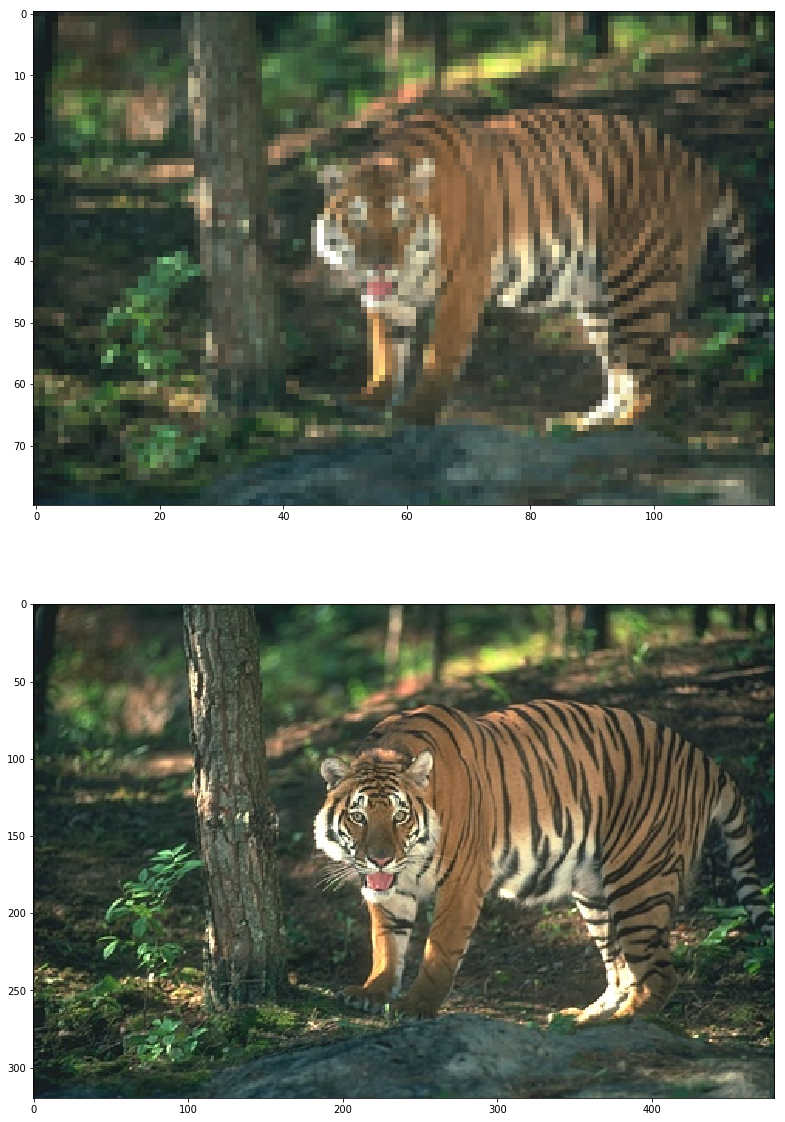

In [22]:
plt.figure(figsize=(30,20))
plt.subplot(211)
plt.imshow((LR_images[6]))
plt.subplot(212)
plt.imshow((HR_images[6]))
plt.show()

In [23]:
#Original_image = np.reshape(LR_images,(LR_images.shape[0],LR_images.shape[1],LR_images.shape[2],1))
print ('shape of original image is %d x %d  x%d  x%d ' %HR_images.shape)
#LR_mnist = np.reshape(LR_mnist,(LR_mnist.shape[0],LR_mnist.shape[1],LR_mnist.shape[2],1))
print ('shape of downsample image is  %d x %d  x%d  x%d  ' %LR_images.shape )

shape of original image is 100 x 320  x480  x3 
shape of downsample image is  100 x 80  x120  x3  


# Bicubic interplation 

In [24]:
from skimage.transform import  resize
temp_bicubic= []
for index in tqdm(range(len(LR_images))):
    temp_bicubic.append(imresize(LR_images[index],size=4.0,interp='bicubic'))
bicubic_LR =np.array(temp_bicubic)
# bicubic_mnist = np.reshape(bicubic_mnist,(bicubic_mnist.shape[0],bicubic_mnist.shape[1],bicubic_mnist.shape[2],1))
bicubic_LR.shape

C:\Users\hasan\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  after removing the cwd from sys.path.


(100, 320, 480, 3)

# Traditional method of recover image from low resolution 

imresize support a lot of image Interpolation methods there I examed 5 of them. 
They are:  
- nearest 
- lanczors
- bilinear 
- cubic 
- bicubic 

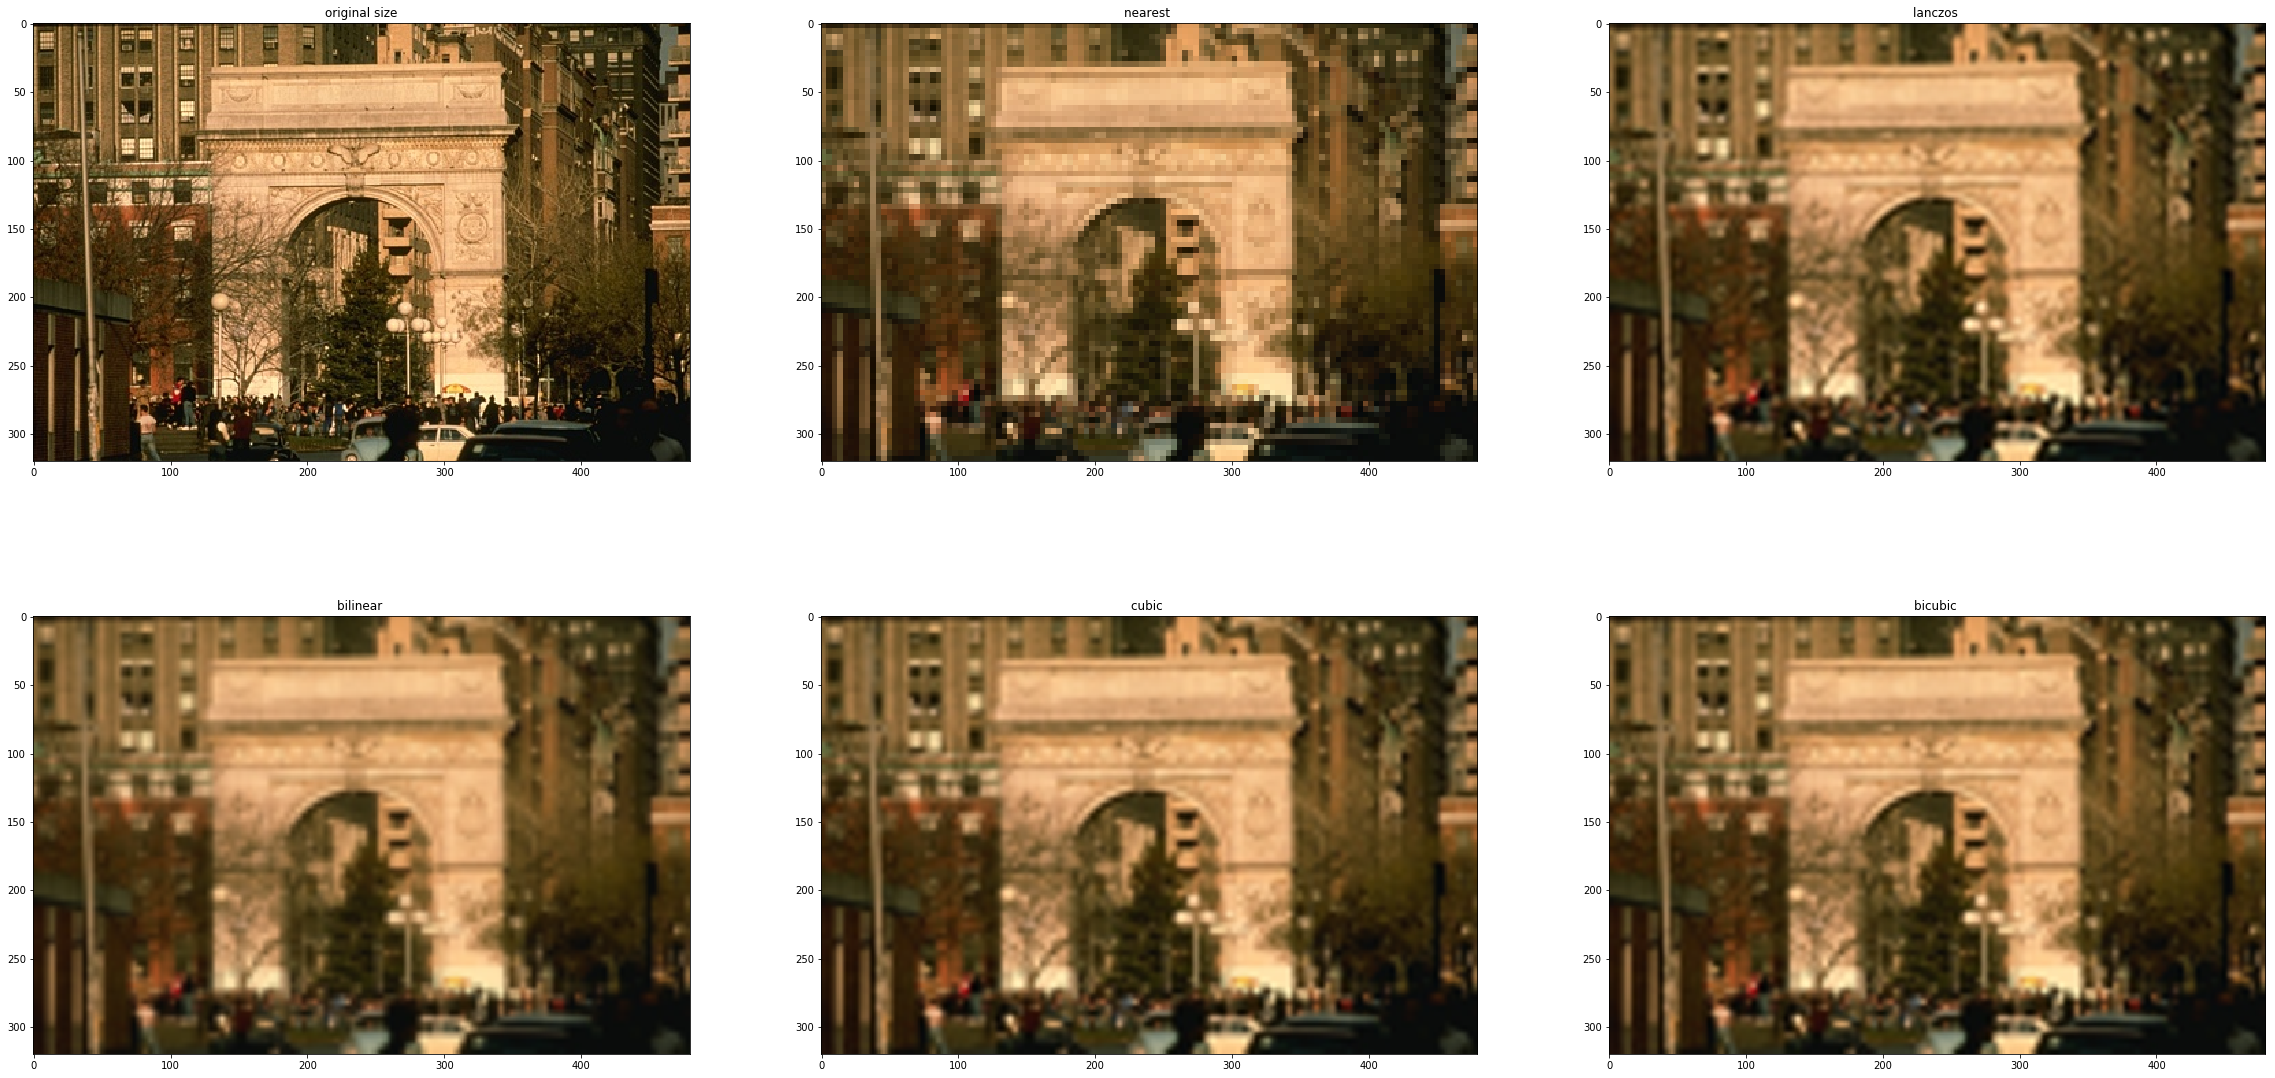

In [25]:
#bicubic_mnist = np.reshape(LR_images,(LR_mnist.shape[0],LR_mnist.shape[1],LR_mnist.shape[2]))
image_index=21
#Img_HR = ycbcr2rgb(HR_images[image_index])
#Img_LR = ycbcr2rgb(HR_images[image_index])
plt.figure(figsize=(40,20))
myplot.plot_comparison(O_image=(HR_images[image_index]),down_image=LR_images[image_index])

# The input is the bicubic-low-resolution image , the output is the original image

Before generate the model. It is very important to normalise the image . 
The SRCNN is only operated in Y channel. Only Y channel is normalised and the CNN is take 1 color channel is input.
The original value of image is between 0 and 255, I will make it between -1 and 1. 


In [26]:
#bicubic_LR_norm = (bicubic_LR-127.5)/128
#HR_images_norm=(HR_images-127.5)/128
#LR_images_norm = (LR_images-127.5)/128
#bicubic_LR=(bicubic_LR-127.5)/128
#LR_Y_channel = np.reshape(LR_images,(LR_images.shape[0],LR_images.shape[1],LR_images.shape[2],1))

#HR_Y_channel = np.reshape(HR_Y_channel,(HR_Y_channel.shape[0],HR_Y_channel.shape[1],HR_Y_channel.shape[2],1))
print ('Max of LR_mnist is %f, Min of LR_mnist is %f' %(bicubic_LR_norm.max() ,bicubic_LR_norm.min() ))
print ('Max of Original_image is %f, Min of Original_image is %f' %(HR_images_norm.max() ,HR_images_norm.min() ))


NameError: name 'bicubic_LR_norm' is not defined

In [27]:
LR_images_norm.shape

NameError: name 'LR_images_norm' is not defined

In [30]:
R=Sequential()
#G.add(Conv2DTranspose(64,(8,8),input_shape = (None,None,3),strides=(4,4),padding='same'))

R.add(Conv2D(64,(9,9),padding='same',input_shape = (None,None,1)))
#G.add(Conv2D(16,(5,5),padding='same'))
#G.add(Dropout(0.9))
R.add(Activation('relu')) 
R.add(Conv2D(32,(1,1),padding='same'))
R.add(Activation('relu'))
# G.add(BatchNormalization())
#G.add(Conv2D(16,(1,1),padding='same'))
#G.add(Activation('relu'))
#G.add(Conv2D(16,(3,3),padding='same'))
#G.add(Activation('relu'))
R.add(Conv2D(1,(5,5),padding='same'))
#G.add(Activation('sigmoid'))
#R.summary()
R.compile(loss='mse',optimizer='adam')
his_R = R.fit(x=bicubic_LR[:,:,:,0:1],y=HR_images[:,:,:,0:1],batch_size=4,epochs=2,verbose=1)

Epoch 1/2
100/100 [==============================] - ETA: 1:24 - loss: 16829.585 - ETA: 1:19 - loss: 13747.114 - ETA: 1:17 - loss: 12105.863 - ETA: 1:13 - loss: 10069.067 - ETA: 1:08 - loss: 9097.323 - ETA: 1:04 - loss: 7865.52 - ETA: 1:01 - loss: 7558.68 - ETA: 57s - loss: 6809.6487 - ETA: 53s - loss: 6681.573 - ETA: 50s - loss: 6140.519 - ETA: 46s - loss: 5633.128 - ETA: 43s - loss: 5211.125 - ETA: 40s - loss: 4944.150 - ETA: 36s - loss: 4918.479 - ETA: 33s - loss: 4744.189 - ETA: 30s - loss: 4495.355 - ETA: 26s - loss: 4292.908 - ETA: 23s - loss: 4112.653 - ETA: 19s - loss: 3935.441 - ETA: 16s - loss: 3769.678 - ETA: 13s - loss: 3876.906 - ETA: 9s - loss: 3757.646 - ETA: 6s - loss: 3744.10 - ETA: 3s - loss: 3667.09 - 83s 830ms/step - loss: 3609.3826
Epoch 2/2
100/100 [==============================] - ETA: 1:18 - loss: 519.912 - ETA: 1:16 - loss: 1726.85 - ETA: 1:13 - loss: 1663.92 - ETA: 1:10 - loss: 1442.94 - ETA: 1:06 - loss: 1592.87 - ETA: 1:02 - loss: 2120.49 - ETA: 58s - loss:

In [31]:
G=Sequential()
#G.add(Conv2DTranspose(64,(8,8),input_shape = (None,None,3),strides=(4,4),padding='same'))

G.add(Conv2D(64,(9,9),padding='same',input_shape = (None,None,1)))
#G.add(Conv2D(16,(5,5),padding='same'))
#G.add(Dropout(0.9))
G.add(Activation('relu')) 
G.add(Conv2D(32,(1,1),padding='same'))
G.add(Activation('relu'))
# G.add(BatchNormalization())
#G.add(Conv2D(16,(1,1),padding='same'))
#G.add(Activation('relu'))
#G.add(Conv2D(16,(3,3),padding='same'))
#G.add(Activation('relu'))
G.add(Conv2D(1,(5,5),padding='same'))
#G.add(Activation('sigmoid'))
#G.summary()
G.compile(loss='mse',optimizer='adam')
his_G = G.fit(x=bicubic_LR[:,:,:,1:2],y=HR_images[:,:,:,1:2],batch_size=4,epochs=2,verbose=1)

Epoch 1/2
100/100 [==============================] - ETA: 1:24 - loss: 13099.824 - ETA: 1:18 - loss: 11368.662 - ETA: 1:13 - loss: 9689.322 - ETA: 1:10 - loss: 7744.37 - ETA: 1:07 - loss: 6468.70 - ETA: 1:04 - loss: 5741.11 - ETA: 1:00 - loss: 5862.53 - ETA: 57s - loss: 5438.8270 - ETA: 53s - loss: 5365.435 - ETA: 50s - loss: 5030.492 - ETA: 47s - loss: 4765.777 - ETA: 43s - loss: 4603.082 - ETA: 40s - loss: 4314.009 - ETA: 36s - loss: 4296.319 - ETA: 33s - loss: 4109.811 - ETA: 30s - loss: 3947.732 - ETA: 26s - loss: 3772.439 - ETA: 23s - loss: 3674.832 - ETA: 20s - loss: 3554.222 - ETA: 16s - loss: 3462.497 - ETA: 13s - loss: 3407.816 - ETA: 10s - loss: 3382.850 - ETA: 6s - loss: 3305.351 - ETA: 3s - loss: 3238.27 - 83s 834ms/step - loss: 3188.0323
Epoch 2/2
100/100 [==============================] - ETA: 1:16 - loss: 3707.38 - ETA: 1:14 - loss: 2596.40 - ETA: 1:12 - loss: 1869.25 - ETA: 1:08 - loss: 1811.79 - ETA: 1:05 - loss: 1816.58 - ETA: 1:02 - loss: 1840.34 - ETA: 1:00 - loss: 

In [32]:
B=Sequential()
#G.add(Conv2DTranspose(64,(8,8),input_shape = (None,None,3),strides=(4,4),padding='same'))

B.add(Conv2D(64,(9,9),padding='same',input_shape = (None,None,1)))
#G.add(Conv2D(16,(5,5),padding='same'))
#G.add(Dropout(0.9))
B.add(Activation('relu')) 
B.add(Conv2D(32,(1,1),padding='same'))
B.add(Activation('relu'))
# G.add(BatchNormalization())
#G.add(Conv2D(16,(1,1),padding='same'))
#G.add(Activation('relu'))
#G.add(Conv2D(16,(3,3),padding='same'))
#G.add(Activation('relu'))
B.add(Conv2D(1,(5,5),padding='same'))
#G.add(Activation('sigmoid'))
#B.summary()
B.compile(loss='mse',optimizer='adam')
his_B = B.fit(x=bicubic_LR[:,:,:,2:3],y=HR_images[:,:,:,2:3],batch_size=4,epochs=2,verbose=1)

Epoch 1/2
100/100 [==============================] - ETA: 1:22 - loss: 4632.54 - ETA: 1:15 - loss: 5853.08 - ETA: 1:11 - loss: 4284.47 - ETA: 1:08 - loss: 4136.22 - ETA: 1:05 - loss: 3850.61 - ETA: 1:02 - loss: 3668.02 - ETA: 58s - loss: 3514.5844 - ETA: 55s - loss: 3305.181 - ETA: 52s - loss: 3302.762 - ETA: 48s - loss: 3317.720 - ETA: 45s - loss: 3128.536 - ETA: 41s - loss: 2937.938 - ETA: 38s - loss: 2781.718 - ETA: 35s - loss: 2685.749 - ETA: 32s - loss: 2817.823 - ETA: 28s - loss: 2698.144 - ETA: 25s - loss: 2630.322 - ETA: 22s - loss: 2522.762 - ETA: 19s - loss: 2443.522 - ETA: 16s - loss: 2358.464 - ETA: 12s - loss: 2375.797 - ETA: 9s - loss: 2317.456 - ETA: 6s - loss: 2294.04 - ETA: 3s - loss: 2240.58 - 81s 807ms/step - loss: 2172.6900
Epoch 2/2
100/100 [==============================] - ETA: 1:16 - loss: 529.257 - ETA: 1:12 - loss: 516.140 - ETA: 1:09 - loss: 1345.78 - ETA: 1:06 - loss: 1131.71 - ETA: 1:03 - loss: 994.3412 - ETA: 1:01 - loss: 1138.25 - ETA: 57s - loss: 1422.25

In [33]:
R.save('SRCNN_SRF4_R.h5')
G.save('SRCNN_SRF4_G.h5')
B.save('SRCNN_SRF4_B.h5')

# Predict 

In [34]:
R=load_model('SRCNN_SRF4_R.h5')
G=load_model('SRCNN_SRF4_G.h5')
B=load_model('SRCNN_SRF4_B.h5')

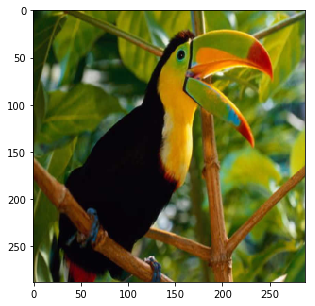

In [36]:
import imageio
mypath = './Set5/image_SRF_4/img_002_SRF_4_HR.png'
value_truth= imageio.imread(mypath)
plt.figure(figsize=(10,5))
plt.imshow(value_truth)

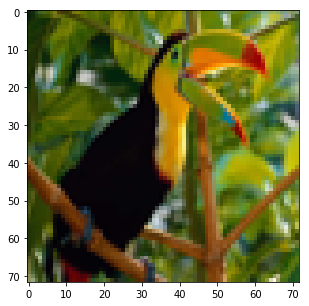

In [38]:
mypath = './Set5/image_SRF_4/img_002_SRF_4_LR.png'
value_pred=imageio.imread(mypath)
plt.figure(figsize=(10,5))
plt.imshow(value_pred)

In [39]:
value_pred_bi=imresize(arr=value_pred,size=4.0,interp='bicubic')
#value_pred=(value_pred-127.5)/128
value_pred=np.reshape(value_pred,(1,value_pred.shape[0],value_pred.shape[1],value_pred.shape[2]))
value_pred_bi = np.reshape(value_pred_bi,(1,value_pred_bi.shape[0],value_pred_bi.shape[1],value_pred_bi.shape[2]))


C:\Users\hasan\Anaconda3\envs\DL\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


In [40]:
value_pred_bi.shape
value_pred.shape


(1, 72, 72, 3)

In [44]:
predict_SR=value_pred_bi.copy()
Rc= R.predict(value_pred_bi[:,:,:,0:1])
Gc= G.predict(value_pred_bi[:,:,:,1:2])
Bc = B.predict(value_pred_bi[:,:,:,2:3])


In [45]:
#predict_SR= G.predict(x=value_pred)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


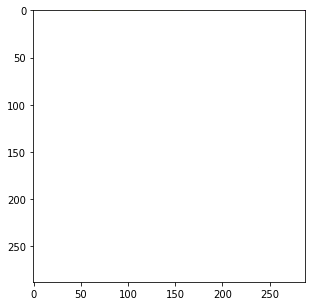

In [46]:
predict_SR=np.zeros((288,288,3))
predict_SR[:,:,0:1] = Rc
predict_SR[:,:,1:2] = Gc
predict_SR[:,:,2:3] = Bc

plt.figure(figsize=(10,5))
plt.imshow(predict_SR)

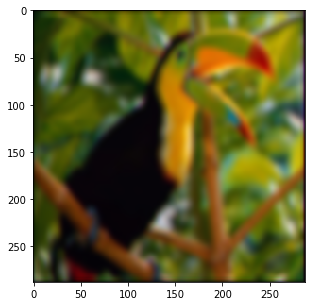

In [47]:
#predict_SR=predict_SR*128+127.5
predict_SR[predict_SR>255]=255
predict_SR[predict_SR<0]=0
predict_SR=predict_SR.astype('uint8')
predict_SR.shape
plt.figure(figsize=(10,5))
plt.imshow(predict_SR)

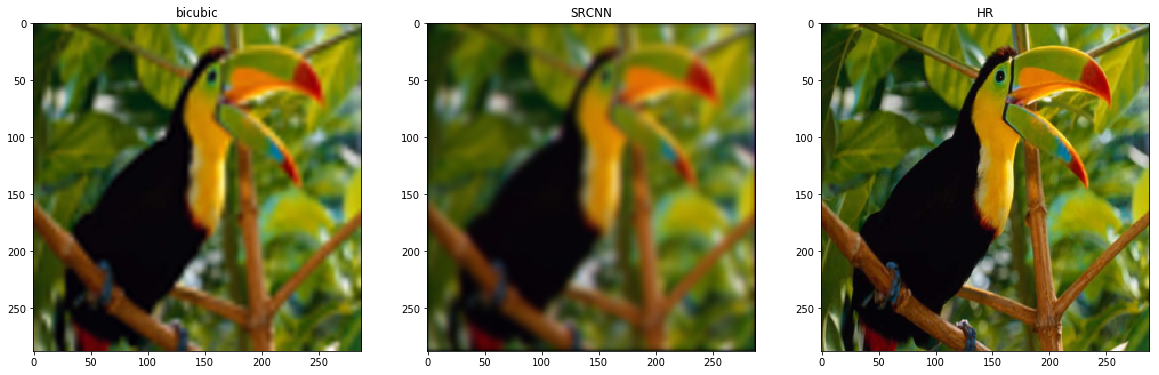

In [48]:
plt.figure(figsize=(20,20))
plt.subplot(131)
plt.title('bicubic')
plt.imshow(value_pred_bi[0].astype('uint8'))
plt.subplot(132)

plt.title('SRCNN')

plt.imshow(predict_SR.astype('uint8'))
plt.subplot(133)

plt.title('HR')

plt.imshow(value_truth.astype('uint8'))

#plt.savefig('SET5_SRF4_02')
plt.show()

<h1 align = 'center' =>Measure PSNR </center>

In [ ]:
compare_psnr(im_true=value_truth,im_test=predict_SR)

In [ ]:
compare_psnr(im_true=value_truth,im_test=value_pred_bi[0])

# Stand alone func

In [ ]:
def super_resolution(img): 
    img=imresize(arr=img,size=4.0,interp='bicubic')
    predict_SR=np.zeros(img.shape)
    img =np.reshape(img,(1,img.shape[0],img.shape[1],3))
    predict_SR[:,:,0:1] = R.predict(img[:,:,:,0:1])
    predict_SR[:,:,1:2] = G.predict(img[:,:,:,1:2])
    predict_SR[:,:,2:3] = B.predict(img[:,:,:,2:3])
    predict_SR[predict_SR>255]=255
    predict_SR[predict_SR<0]=0
    predict_SR=predict_SR.astype('uint8')
    return predict_SR,img[0]

In [ ]:
img.shape

In [ ]:
def funcplot(value_pred_bi,predict_SR,value_truth,name):
    plt.figure(figsize=(16,8))
    plt.subplot(131)
    plt.xticks([])
    plt.yticks([])
    plt.title('bicubic')
    plt.imshow(value_pred_bi.astype('uint8'))
    plt.subplot(132)

    plt.xticks([])
    plt.yticks([])
    plt.title('SRCNN')

    plt.imshow(predict_SR.astype('uint8'))
    plt.subplot(133)

    plt.xticks([])
    plt.yticks([])
    plt.title('HR')

    plt.imshow(value_truth.astype('uint8'))

    plt.savefig('./sepRGB/'+name)
    plt.show()

In [ ]:
value_truth.shape

In [ ]:
path = './data/Set14/image_SRF_4/'
psrn_o =[]
psrn_n =[]
for files in listdir(path):
    if 'LR' in files:
        img = imread(path+files)
        SR ,value_pred_bi= super_resolution(img)
        files= files.replace('L','H')
        value_truth= imread(path+files)
        psrn_o.append(compare_psnr(im_true=value_truth,im_test=SR))
        psrn_n.append(compare_psnr(im_true=value_truth,im_test=value_pred_bi))
        funcplot(value_pred_bi,SR,value_truth,files)
psrn_o = np.array(psrn_o)
psrn_n = np.array(psrn_n)
print (str(psrn_o) +'\n' + str(psrn_n) )

In [ ]:
from keras.callbacks import Callback

callback = Callback()
his_R = R.fit(x=bicubic_LR[:,:,:,0:1],y=HR_images[:,:,:,0:1],batch_size=4,epochs=5,verbose=1,callbacks=[callback])

In [ ]:
his_R

In [ ]:
import keras 
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))